# Imports

In [1]:
import importlib.resources as resources
import logging
import matplotlib.pyplot as plt
import numpy as np

from anypick_dk.grounded_sam_wrapper import GroundedSamWrapper
from anypick_dk.planner import Planner
from anypick_dk.sim_environment import SimEnvironment

logging.basicConfig(level=logging.INFO)

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
scenario_file = str(resources.files("anypick_dk") / "scenarios" / "shelf_with_objects.yaml")
sim_env = SimEnvironment(scenario_file)
planner = Planner(sim_env)
sim_env.publish_diagram()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# View Camera Images

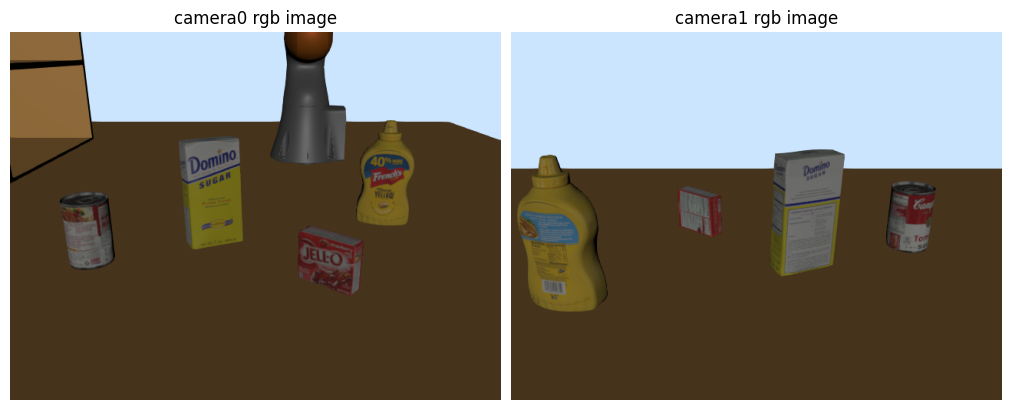

In [3]:
cameras = ["camera0", "camera1"]
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = sim_env.station.GetOutputPort(f"{cam}.rgb_image").Eval(sim_env.station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)[:,:,:-1]
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

plt.show()

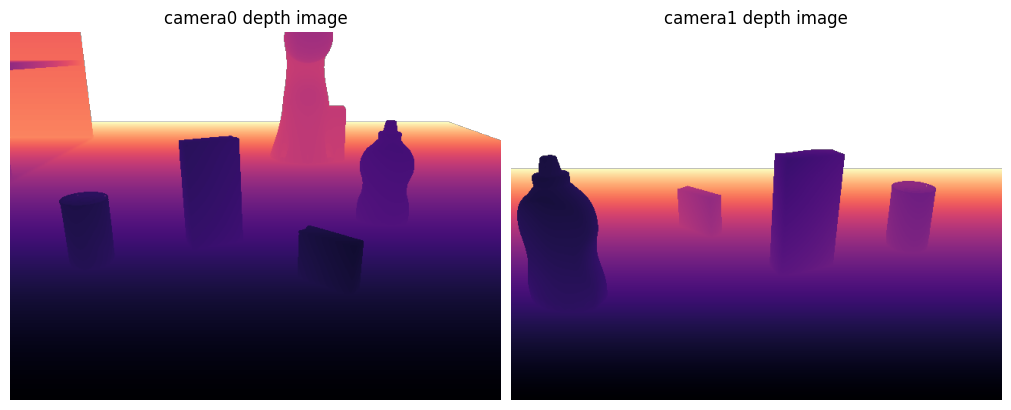

In [4]:
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = sim_env.station.GetOutputPort(f"{cam}.depth_image").Eval(sim_env.station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

plt.show()

# Run GroundedSAM

Working prompts are:
- "the mustard bottle"
- "the red box" or "the red jello box"
- "the yellow and white box"
- "the can"

In [5]:
gdsam = GroundedSamWrapper()

final text_encoder_type: bert-base-uncased


In [12]:
prompt = ["the can"]
for cam in cameras:
    img = sim_env.station.GetOutputPort(f"{cam}.rgb_image").Eval(sim_env.station_context)
    img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)[:,:,:-1]
    img_bgr = img[:, :, ::-1]
    gdsam.detect_and_segment(img_bgr, prompt, box_threshold=0.5)
    gdsam.annotate_and_save(img_bgr, output_path=f"{cam}_detection_test.png")

INFO:anypick_dk.grounded_sam_wrapper:Saved annotated image to camera0_detection_test.png
INFO:anypick_dk.grounded_sam_wrapper:Saved annotated image to camera1_detection_test.png
